### Importing Libraries

In [1]:
import os
import math
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as CM

import h5py
import json
import scipy
import scipy.io as io
from scipy.spatial import KDTree
from scipy.ndimage.filters import gaussian_filter

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Normalize, Compose, CenterCrop

In [2]:
#Setting the seed to generate the same random data every time the kernel is restarted
#torch.manual_seed(8)

In [3]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True, dtype=torch.float)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
#Choosing GPU as the default device for model execution

device = get_default_device()
print(device)

cuda


In [6]:
list(range(torch.cuda.device_count()))

[0, 1, 2, 3]

In [7]:
#torch.cuda.device_count()

In [8]:
#torch.cuda.current_device()

In [9]:
#torch.cuda.device(1)

In [10]:
#torch.cuda.get_device_name(1)

In [11]:
# To determine if we will be pinning memory during data loading

pin_memory = True if device.type == "cuda" else False
pin_memory

True

### Dataset Preparation - ShanghaiTech

In [12]:
#Setting the paths to dataset

dataset = 'Dataset_Crowd_Counting/Shanghai_Tech/ShanghaiTech' #For Linux

_partA = 'part_A'
_partB = 'part_B'
_train_path = 'train_data'
_test_path = 'test_data'
_images = 'images'
_targets = 'ground-truth'

#root = 'C:/Users/subir/Downloads/GNR-Project/'

In [13]:
#Setting the paths to dataset

root = os.path.join(os.getcwd(), dataset)
partA_train_data = os.path.join(root, _partA, _train_path, _images)
partA_train_target = os.path.join(root, _partA, _train_path, _targets)
partA_test_data = os.path.join(root, _partA, _test_path, _images)
partA_test_target = os.path.join(root, _partA, _test_path, _targets)

partB_train_data = os.path.join(root, _partB, _train_path, _images)
partB_train_target = os.path.join(root, _partB, _train_path, _targets)
partB_test_data = os.path.join(root, _partB, _test_path, _images)
partB_test_target = os.path.join(root, _partB, _test_path, _targets)

In [14]:
# partA_test_target

In [15]:
#Fetching list of all filenames present in a path to images

def list_images(data_path):
    
    #List to hold all training/testing images filenames
    image_list = []
    
    #Iterating over the training/testing images to fetch all filenames and appending it to the filenames list
    for img_path in os.listdir(data_path):
        image_list.append(img_path)
        
    return image_list

In [16]:
train_image_list_A = list_images(partA_train_data)

#Display the length of the list of all training images filename
print(len(train_image_list_A))

#Display the list of one such training image filename
print(train_image_list_A[10])

300
IMG_41.jpg


In [17]:
test_image_list_A = list_images(partA_test_data)

#Display the length of the list of all testing images filename
print(len(test_image_list_A))

#Display the list of one such testing image filename
print(test_image_list_A[10])

182
IMG_89.jpg


In [18]:
train_image_list_B = list_images(partB_train_data)

#Display the length of the list of all training images filename
print(len(train_image_list_B))

#Display the list of one such training image filename
print(train_image_list_B[10])

400
IMG_42.jpg


In [19]:
test_image_list_B = list_images(partB_test_data)

#Display the length of the list of all testing images filename
print(len(test_image_list_B))

#Display the list of one such testing image filename
print(test_image_list_B[10])

316
IMG_41.jpg


In [20]:
#This function definition code is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet

#Function definition for generation of ground-truth

def gaussian_filter_density(gt):
    
    #print(gt.shape)
    density_map = np.zeros(gt.shape, dtype=np.float32) #Initializing a matrix with values=0
    gt_count = np.count_nonzero(gt) #Counting the no of people in the density map
    
    #If there are 0 people in an image, then the zero density map is returned
    if gt_count == 0:
        return density_map

    leafsize = 2048
    
    gt_1 = np.nonzero(gt)[1] #The no of head indexes along the columns
    gt_0 = np.nonzero(gt)[0] #The no of head indexes along the rows
    heads = np.stack((gt_1, gt_0), axis=1) #Creating a matrix of head indexes

    # build kdtree
    tree = KDTree(heads, leafsize=leafsize)
    
    # query kdtree
    # Find the average distances for each head with K(=4) nearest heads in the head annotations
    distances, locations = tree.query(heads, k=4) #k=4 as per the paper

    for i, hd in enumerate(heads):
        hd2d = np.zeros(gt.shape, dtype=np.float32)
        hd2d[hd[1], hd[0]] = 1
        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1 #Computing the standard deviation of Gaussian kernel
        else:
            sigma = np.average(np.array(gt.shape))/2 #Computing the standard deviation of Gaussian kernel
        density_map += gaussian_filter(hd2d, sigma, mode='constant') #Convolving using the 2D Gaussian filter
    
    return density_map

In [21]:
plt.rcParams["figure.figsize"] = (30, 20) #Setting the size of the plot

In [22]:
def create_density_map(image_list, data_path, target_path):
    count = 0
    
    #Iterating over all image filenames
    for _path in image_list:
        str1 = 'GT_' + _path
        str1 = str1.replace('.jpg', '.mat')
        img_path = os.path.join(data_path, _path) #Creating the path to the image
        gt_path = os.path.join(target_path, str1)
        h5_path = gt_path.replace('ShanghaiTech', 'DensityMaps')
        str2 = h5_path.replace('.mat', '.h5')  #Creating the path to the density map
        
        #print(str2)
        #print(img_path)
        #print(gt_path)
        #print(h5_path)
        #print("----------------")
        
    
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Load and read the image using cv2 as BGR format
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converting the image into RGB
        
        #Plotting the image
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title('Image')
    
    
        r, c, ch = img_rgb.shape
        #print(r, c)

        heads = np.zeros((r, c))
        
        #Fetching the .mat file and reading the values
        mat = io.loadmat(gt_path)
        gt = mat["image_info"][0][0][0][0][0]
        gt = gt.astype(int)
        #print(gt)
    
        for i in range(len(gt)):
            heads[gt[i][1], gt[i][0]] = 1
            
        #Using the 2D Gaussian filter to generate the density map from head annotations
        density = gaussian_filter_density(heads)
        #print(density.shape)
        
        #Storing the density map as a h5py file in the specified path
        with h5py.File(str2, 'w') as hf:
            hf['density_map'] = density
        
        #Reading the density map from the h5py file
        gt_file = h5py.File(str2, 'r')
        groundtruth = np.asarray(gt_file['density_map'])
        print(count, np.sum(groundtruth)) #Counting the no of persons in a density map
        count+=1
        
        #Plotting the density map
        plt.subplot(1, 2, 2)
        plt.imshow(groundtruth, cmap=CM.jet)
        plt.axis('off')
        plt.title('Density Map')
        
        plt.show()
    
        gt_file.close()
        #return density
        break

0 335.9118


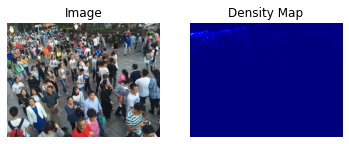

In [23]:
#Generate density map from head annotations, and displaying a sample input image and it's density map
create_density_map(train_image_list_B, partB_train_data, partB_train_target)

In [24]:
#Generate density map from head annotations, and displaying a sample input image and it's density map
#create_density_map(test_image_list_B, partB_test_data, partB_test_target)

In [25]:
#Generate density map from head annotations, and displaying a sample input image and it's density map
#create_density_map(train_image_list_A, partA_train_data, partA_train_target)

In [26]:
#Generate density map from head annotations, and displaying a sample input image and it's density map
#create_density_map(test_image_list_A, partA_test_data, partA_test_target)

### Dataset Preparation - ShanghaiTech Part_A (highly congested scenes, 482 images with 241667 persons)

In [27]:
#Class definition for data and labels extraction and pre-processing
class Dataset_Preparation(Dataset):
    def __init__(self, imagePaths, densityPaths, transforms, transforms2):
        self.imagePaths = imagePaths #store the image filepath
        self.densityPaths = densityPaths #store the density filepath
        self.transforms = transforms #store the augmentation transforms
        self.transforms2 = transforms2
        
    def __len__(self):
        return len(self.imagePaths) #return the number of samples in the dataset
    
    def __getitem__(self, idx):
        imagePath = self.imagePaths[idx] #Obtain the image from the imagepath using the current index
        densityPath = self.densityPaths[idx] #Obtain the density map of the image from the densityPaths using the current index
        
        image = cv2.imread(imagePath) #Load and read the image from disk in BGR format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Converting BGR to RGB format
        image = image / 255 #Normalizing to 0-1 range of intensity values
        
        #Fetching the density map from target density path
        gt = h5py.File(densityPath, 'r')
        density = np.asarray(gt['density_map'])
        
        #Apply the specified transform on the image
        if self.transforms is not None:
            image = self.transforms(image)
        
        #Apply the specified transform on the density map
        if self.transforms2 is not None:
            density = self.transforms2(density)
              
        #return a tuple of the image and its density map
        return (image, density)

In [28]:
#Function definition to prepare the list of image and density maps
def prepare_list(image_filenames, image_path, target_path):
    images = []
    targets = []
    
    for _path in image_filenames:
        img_path = os.path.join(image_path, _path)
        
        str1 = 'GT_' + _path
        str1 = str1.replace('.jpg', '.h5')
        gt_path = os.path.join(target_path, str1)
        h5_path = gt_path.replace('ShanghaiTech', 'DensityMaps')
        
        images.append(img_path)
        targets.append(h5_path)
        
    return images, targets

In [29]:
#train_image_list_B, partB_train_data, partB_train_target
#test_image_list_B, partB_test_data, partB_test_target

_trainImages = partA_train_data
_trainTargets = partA_train_target

_testImages = partA_test_data
_testTargets = partA_test_target

In [30]:
trainImages, trainTargets = prepare_list(train_image_list_A, _trainImages, _trainTargets)
testImages, testTargets = prepare_list(test_image_list_A, _testImages, _testTargets)

In [31]:
print(len(trainImages))
print(len(trainTargets))
print(len(testImages))
print(len(testTargets))

300
300
182
182


In [32]:
# print(trainImages[52])
# print(testTargets[52])

In [33]:
#Defining transformations to the image and density map

transforms = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

transforms2 = ToTensor()

#Creating the train and test datasets
trainDS = Dataset_Preparation(imagePaths=trainImages, densityPaths=trainTargets, transforms=transforms, transforms2=transforms2)
testDS = Dataset_Preparation(imagePaths=testImages, densityPaths=testTargets, transforms=transforms, transforms2=transforms2)

In [34]:
len(trainDS)

300

In [35]:
len(testDS[0])

2

##### Working on a much smaller subset of dataset for evaluating model correctness

##### -----------------------------------------------------------------------------------------------------------------

In [36]:
# t = int(0.5 * len(trainDS))
# v = len(trainDS) - t
# t_data, v_data = random_split(trainDS, [t, v])

In [37]:
# print(len(t_data))
# print(len(v_data))

In [38]:
# t = int(0.8 * len(t_data))
# v = len(t_data) - t
# train_dataset, val_dataset = random_split(t_data, [t, v])

In [39]:
# print(len(train_dataset))
# print(len(val_dataset))

##### -----------------------------------------------------------------------------------------------------------------

In [40]:
#Splitting the training dataset into 80% training and 20% validation

train_size = int(0.80 * len(trainDS))
val_size = len(trainDS) - train_size
train_dataset, val_dataset = random_split(trainDS, [train_size, val_size])

In [41]:
print(train_dataset)
print(val_dataset)
print(len(train_dataset))
print(len(val_dataset))

240
60


In [42]:
#Specifying the batch-size of the model
batch_size = 1

In [43]:
#Creating the training, validation and test data loaders

trainLoader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=pin_memory, num_workers=os.cpu_count())
valLoader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, pin_memory=pin_memory, num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False, batch_size=batch_size, pin_memory=pin_memory, num_workers=os.cpu_count())

In [44]:
#Moving the training, validation and test data handlers into the device for execution

trainLoader = DeviceDataLoader(trainLoader, device)
valLoader = DeviceDataLoader(valLoader, device)
testLoader = DeviceDataLoader(testLoader, device)

In [45]:
len(trainLoader)

240

In [46]:
len(valLoader)

60

In [47]:
# for xb, yb in valLoader:
#     print(xb.shape)
#     print(yb.shape)
#     break

In [48]:
len(testLoader)

182

In [49]:
# for xb, yb in testLoader:
#     print(xb.shape)
#     print(yb.shape)
#     break

### Network Architectcure

In [50]:
def relu():
    return nn.ReLU()

def batch_norm(ni):
    return nn.BatchNorm2d(ni)

def conv_2d(ni, nf, ks=3, stride=1, dilation=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=(ks//2) * dilation, dilation=dilation, bias=True)

def upsample(size, scale_factor=8):
    return nn.UpsamplingBilinear2d(size=size)

In [51]:
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        dim = [3, 64, 128, 256, 512]
        
         
        #Layer: conv0, Output: [batch_size, 64, w, h]
        self.conv0 = nn.Sequential(
                    conv_2d(dim[0], dim[1]),
                    relu())
        
        #Layer: conv1, Output: [batch_size, 64, w, h]
        self.conv1 = nn.Sequential(
                    conv_2d(dim[1], dim[1]),
                    relu())
        
        #Layer: conv2, Output: [batch_size, 128, w/2, h/2]
        self.conv2 = nn.Sequential(
                    conv_2d(dim[1], dim[2]),
                    relu())
        
        #Layer: conv3, Output: [batch_size, 128, w/2, h/2]
        self.conv3 = nn.Sequential(
                    conv_2d(dim[2], dim[2]),
                    relu())
        
        #Layer: conv4, Output: [batch_size, 256, w/4, h/4]
        self.conv4 = nn.Sequential(
                    conv_2d(dim[2], dim[3]),
                    relu())
        
        #Layer: conv5, Output: [batch_size, 256, w/4, h/4]
        self.conv5 = nn.Sequential(
                    conv_2d(dim[3], dim[3]),
                    relu())
        
        #Layer: conv6, Output: [batch_size, 256, w/4, h/4]
        self.conv6 = nn.Sequential(
                    conv_2d(dim[3], dim[3]),
                    relu())
        
        #Layer: conv7, Output: [batch_size, 512, w/8, h/8]
        self.conv7 = nn.Sequential(
                    conv_2d(dim[3], dim[4]),
                    relu())
        
        #Layer: conv8, Output: [batch_size, 512, w/8, h/8]
        self.conv8 = nn.Sequential(
                    conv_2d(dim[4], dim[4]),
                    relu())
        
        #Layer: conv9, Output: [batch_size, 512, w/8, h/8]
        self.conv9 = nn.Sequential(
                    conv_2d(dim[4], dim[4]),
                    relu())
        
        #Layer: conv10, Output: [batch_size, 512, w/8, h/8]
        self.conv10 = nn.Sequential(
                    conv_2d(dim[4], dim[4], dilation=2),
                    relu())
        
        #Layer: conv11, Output: [batch_size, 512, w/8, h/8]
        self.conv11 = nn.Sequential(
                    conv_2d(dim[4], dim[4], dilation=2),
                    relu())
        
        #Layer: conv12, Output: [batch_size, 512, w/8, h/8]
        self.conv12 = nn.Sequential(
                    conv_2d(dim[4], dim[4], dilation=2),
                    relu())
        
        #Layer: conv13, Output: [batch_size, 256, w/8, h/8]
        self.conv13 = nn.Sequential(
                    conv_2d(dim[4], dim[3], dilation=2),
                    relu())
        
        #Layer: conv14, Output: [batch_size, 128, w/8, h/8]
        self.conv14 = nn.Sequential(
                    conv_2d(dim[3], dim[2], dilation=2),
                    relu())
        
        #Layer: conv15, Output: [batch_size, 64, w/8, h/8]
        self.conv15 = nn.Sequential(
                    conv_2d(dim[2], dim[1], dilation=2),
                    relu())
        
        #Layer: conv16, Output: [batch_size, 1, w/8, h/8]
        self.conv16 = conv_2d(dim[1], 1, ks=1)


        self.maxpool = nn.MaxPool2d(2, stride=2)

        #self.scale = nn.UpsamplingBilinear2d(scale_factor=8)

        
    def forward(self, x):
        _, _, h, w = x.shape
        
        conv0 = self.conv0(x)      #Output: [batch_size, 64, w, h]
        conv1 = self.conv1(conv0)  #Output: [batch_size, 64, w, h]
        mp1 = self.maxpool(conv1)  #Output: [batch_size, 64, w/2, h/2]

        conv2 = self.conv2(mp1)    #Output: [batch_size, 128, w/2, h/2]
        conv3 = self.conv3(conv2)  #Output: [batch_size, 128, w/2, h/2]
        mp2 = self.maxpool(conv3)  #Output: [batch_size, 128, w/4, h/4]

        conv4 = self.conv4(mp2)    #Output: [batch_size, 256, w/4, h/4]
        conv5 = self.conv5(conv4)  #Output: [batch_size, 256, w/4, h/4]
        conv6 = self.conv6(conv5)  #Output: [batch_size, 256, w/4, h/4]
        mp3 = self.maxpool(conv6)  #Output: [batch_size, 256, w/8, h/8]

        conv7 = self.conv7(mp3)    #Output: [batch_size, 512, w/8, h/8]
        conv8 = self.conv8(conv7)  #Output: [batch_size, 512, w/8, h/8]
        conv9 = self.conv9(conv8)  #Output: [batch_size, 512, w/8, h/8]

        conv10 = self.conv10(conv9)   #Output: [batch_size, 512, w/8, h/8]
        conv11 = self.conv11(conv10)  #Output: [batch_size, 512, w/8, h/8]
        conv12 = self.conv12(conv11)  #Output: [batch_size, 512, w/8, h/8]

        conv13 = self.conv13(conv12)  #Output: [batch_size, 256, w/8, h/8]
        conv14 = self.conv14(conv13)  #Output: [batch_size, 128, w/8, h/8]
        conv15 = self.conv15(conv14)  #Output: [batch_size, 64, w/8, h/8]
        conv16 = self.conv16(conv15)  #Output: [batch_size, 1, w/8, h/8]
        

        #scale = self.scale(conv16)    #Output: [batch_size, 1, w, h]
        up = upsample((h,w))
        scale = up(conv16)             #Output: [batch_size, 1, w, h]

        return scale

In [52]:
# model = CSRNet()

# #model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
# #model.to("cuda")
# to_device(model, device)

In [53]:
#Function definition to initialize the back-end of the model with normal distribution (sigma=0.01)

def initialize_backend(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            #torch.manual_seed(8)
            nn.init.normal_(m.weight.data, std=0.01)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
                
    return model

In [54]:
#Creating an instance of the model 
model = CSRNet()

#Initializing the backend
model = initialize_backend(model)

#to_device(model, device)

In [55]:
#Importing the vgg16 model for using its pre-training weights of first 10 layers to the CSRNet architecture
from torchvision import models

vgg = models.vgg16(pretrained = True)
#vgg.features

In [56]:
#Starting training of the CSRNet from ImageNet weights

model.conv0[0].weight.data.copy_(vgg.features[0].weight.data)
model.conv0[0].bias.data.copy_(vgg.features[0].bias.data)

model.conv1[0].weight.data.copy_(vgg.features[2].weight.data)
model.conv1[0].bias.data.copy_(vgg.features[2].bias.data)

model.conv2[0].weight.data.copy_(vgg.features[5].weight.data)
model.conv2[0].bias.data.copy_(vgg.features[5].bias.data)

model.conv3[0].weight.data.copy_(vgg.features[7].weight.data)
model.conv3[0].bias.data.copy_(vgg.features[7].bias.data)

model.conv4[0].weight.data.copy_(vgg.features[10].weight.data)
model.conv4[0].bias.data.copy_(vgg.features[10].bias.data)

model.conv5[0].weight.data.copy_(vgg.features[12].weight.data)
model.conv5[0].bias.data.copy_(vgg.features[12].bias.data)

model.conv6[0].weight.data.copy_(vgg.features[14].weight.data)
model.conv6[0].bias.data.copy_(vgg.features[14].bias.data)

model.conv7[0].weight.data.copy_(vgg.features[17].weight.data)
model.conv7[0].bias.data.copy_(vgg.features[17].bias.data)

model.conv8[0].weight.data.copy_(vgg.features[19].weight.data)
model.conv8[0].bias.data.copy_(vgg.features[19].bias.data)

model.conv9[0].weight.data.copy_(vgg.features[21].weight.data)
model.conv9[0].bias.data.copy_(vgg.features[21].bias.data)

print("VGG first 10 layer weights copied ...")

VGG first 10 layer weights copied ...


In [57]:
#Moving the model to GPU device
to_device(model, device)

CSRNet(
  (conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv7): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv8): Sequential(
    (0): Conv2d

In [58]:
# for name, param in model.named_parameters():
#     print(name)#, param.data)

In [59]:
from torchsummary import summary

summary(model, input_size=(3, 1024, 768))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-5                       73,856
|    └─ReLU: 2-6                         --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-7                       147,584
|    └─ReLU: 2-8                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-9                       295,168
|    └─ReLU: 2-10                        --
├─Sequential: 1-6                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                       

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-5                       73,856
|    └─ReLU: 2-6                         --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-7                       147,584
|    └─ReLU: 2-8                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-9                       295,168
|    └─ReLU: 2-10                        --
├─Sequential: 1-6                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                       

#### Testing the output data generated by the model with a sample input

In [60]:
input1 = torch.randn(1, 3, 111, 55)

In [61]:
input1 = input1.cuda()

In [62]:
output1 = model(input1)
print(output1.shape)

torch.Size([1, 1, 111, 55])


### Training and Validation of the model

In [63]:
#This function definition code is re-used from my own github codebase, 
#                   link: https://github.com/subirkumarparida/TP-GAN/blob/main/support/ResNet.ipynb

def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    #Generate predictions
    preds = model(xb)

    #Calculate loss
    loss = loss_func(preds, yb)

    if opt is not None:
        #Compute gradients
        loss.backward()

        #update parameters
        opt.step()

        #Reset Gradients
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(preds, yb)
   
    return loss.item(), len(xb), metric_result

In [64]:
#This function definition code is re-used from my own github codebase, 
#                   link: https://github.com/subirkumarparida/TP-GAN/blob/main/support/ResNet.ipynb

def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]

        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)

        #Total size of the dataset
        total = np.sum(nums)

        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        
    if metric is not None:
        #Avg of metric across batches
        avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [65]:
#This function definition code is re-used from my own github codebase, 
#                   link: https://github.com/subirkumarparida/TP-GAN/blob/main/support/ResNet.ipynb

def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, opt_fn=None, metric=None):
    train_losses, val_losses, val_metrics = [], [], []
    
    #instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr, momentum=0.95, weight_decay=5*1e-4)
        
    for epoch in range(epochs):
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        #Record the loss and metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        #Print progress:
        print('Epoch [{}/{}], Train_loss: {:.8f}, Val_loss: {:.8f}, {}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
        
        #Saving the model parameters periodically to retain later
        #torch.save(model.state_dict(), str(epoch+1) + 'csrnet.pth')
        #print("Model saved for epoch: " + str(epoch+1))
    
    return train_losses, val_losses, val_metrics

In [66]:
#Loss function : L2 squared loss
loss_fn = nn.MSELoss()

In [67]:
#Evaluation Metric: MAE or MSE
def eval_metric(pred, actual):
    
    actual_count = torch.sum(actual).item()
    pred_count = torch.sum(pred).item()
    
    diff = np.abs(actual_count - pred_count)

    return diff

#### Evaluating the model on the validation dataset before beginning of training

In [68]:
val_loss, _, val_acc = evaluate(model, loss_fn, valLoader, eval_metric)

In [69]:
print('Loss: {:.8f}, MAE: {:.4f}'.format(val_loss, val_acc))

Loss: 0.00001405, MAE: 547.0208


In [70]:
#Setting the hyper-parameters of teh model

num_epochs = 10
lr = 0.00001

#opt_func=None
#opt_func = torch.optim.Adam

opt_func = torch.optim.SGD

In [71]:
#Training the model
history = fit(num_epochs, model, loss_fn, trainLoader, valLoader, lr, opt_func, eval_metric)

Epoch [1/10], Train_loss: 0.00000136, Val_loss: 0.00001383, eval_metric: 492.0608
Epoch [2/10], Train_loss: 0.00000006, Val_loss: 0.00001363, eval_metric: 441.1690
Epoch [3/10], Train_loss: 0.00000175, Val_loss: 0.00001346, eval_metric: 403.4113
Epoch [4/10], Train_loss: 0.00000467, Val_loss: 0.00001333, eval_metric: 377.3812
Epoch [5/10], Train_loss: 0.00001793, Val_loss: 0.00001321, eval_metric: 356.1177
Epoch [6/10], Train_loss: 0.00000077, Val_loss: 0.00001312, eval_metric: 341.3384
Epoch [7/10], Train_loss: 0.00000188, Val_loss: 0.00001304, eval_metric: 330.3494
Epoch [8/10], Train_loss: 0.00000340, Val_loss: 0.00001298, eval_metric: 324.7905
Epoch [9/10], Train_loss: 0.00003622, Val_loss: 0.00001292, eval_metric: 322.0475
Epoch [10/10], Train_loss: 0.00003099, Val_loss: 0.00001288, eval_metric: 321.2236


In [72]:
#print(history)

In [73]:
train_losses, val_losses, val_metrics = history

In [74]:
def plot_accuracies(val_metrics):
    plt.plot(val_metrics, '-o')
    plt.xlabel('epoch')
    plt.ylabel('MAE/MSE')
    plt.title('MAE/MSE vs. No. of epochs')

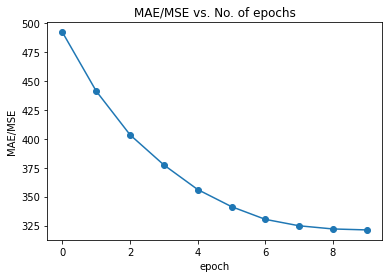

In [75]:
#Plot the MAE vs no of epochs
plot_accuracies(val_metrics)

#### Computing the Testing score

In [78]:
result = evaluate(model, loss_fn, testLoader, eval_metric)
print(result[0], result[2])

8.164923729379683e-06 250.12314700032329


#### Selecting a model that doesn't overfit the training data

In [79]:
# #Loading the modle with the lowest possible validation error - Early stopping approach

# model.load_state_dict(torch.load('4csrnet.pth'))
# model.eval()

In [80]:
# #Evaluating the best model on the testing dataset

# result2 = evaluate(model, loss_fn, testLoader, eval_metric)
# print(result2[0], result2[2])

### Generating a few output maps

In [81]:
def prepare_plot(image, origTarget, predTarget, actualCount, predCount):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    plt.grid(False)
    
    
    ax[0].imshow(image)
    ax[1].imshow(origTarget, cmap=CM.jet)
    ax[2].imshow(predTarget, cmap=CM.jet)
    
    ax[0].set_title("Image", fontsize=25)
    ax[1].set_title("Original Density, Count = " + str(actualCount), fontsize=25)
    ax[2].set_title("Predicted Density, Count = " + str(predCount), fontsize=25)
    
    #Turning the axis off
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    
    figure.tight_layout()
    figure.show()

In [82]:
def make_predictions(model, dataLoader, no_of_samples=3):
    with torch.no_grad():
        #set the model in evaluation mode
        model.eval()
        
        for xb, yb in testLoader:
            pred = model(xb)
            
            actual_count = torch.sum(yb).item()
            pred_count = torch.sum(pred).item()
            
            actual_count = np.round(actual_count)
            pred_count = np.round(pred_count)
            #print("Original crowd count: " + str(actual_count))
            #print("Predicted crowd count: " + str(pred_count))
    
            xb = xb.cpu().numpy() #Convert the tensor input into a numpy object
            xb = np.squeeze(xb)
            xb = np.transpose(xb, (1, 2, 0)) #Shifting the channel into the 3rd dimension          
            #xb[:, :, 0] = (xb[:, :, 0] * 0.229) + 0.485
            #xb[:, :, 1] = (xb[:, :, 1] * 0.224) + 0.456
            #xb[:, :, 2] = (xb[:, :, 2] * 0.225) + 0.406  
            xb = xb * 255 #Scaling the inputs for display
            #xb = xb.astype(np.uint8)

            yb = yb.cpu().numpy() #Convert the tensor input into a numpy object
            yb = np.squeeze(yb)

            pred = pred.cpu().numpy() #Convert the tensor input into a numpy object
            pred = np.squeeze(pred)

            prepare_plot(xb, yb, pred, actual_count, pred_count)
            
            no_of_samples-= 1
            if(no_of_samples <= 0):
                break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


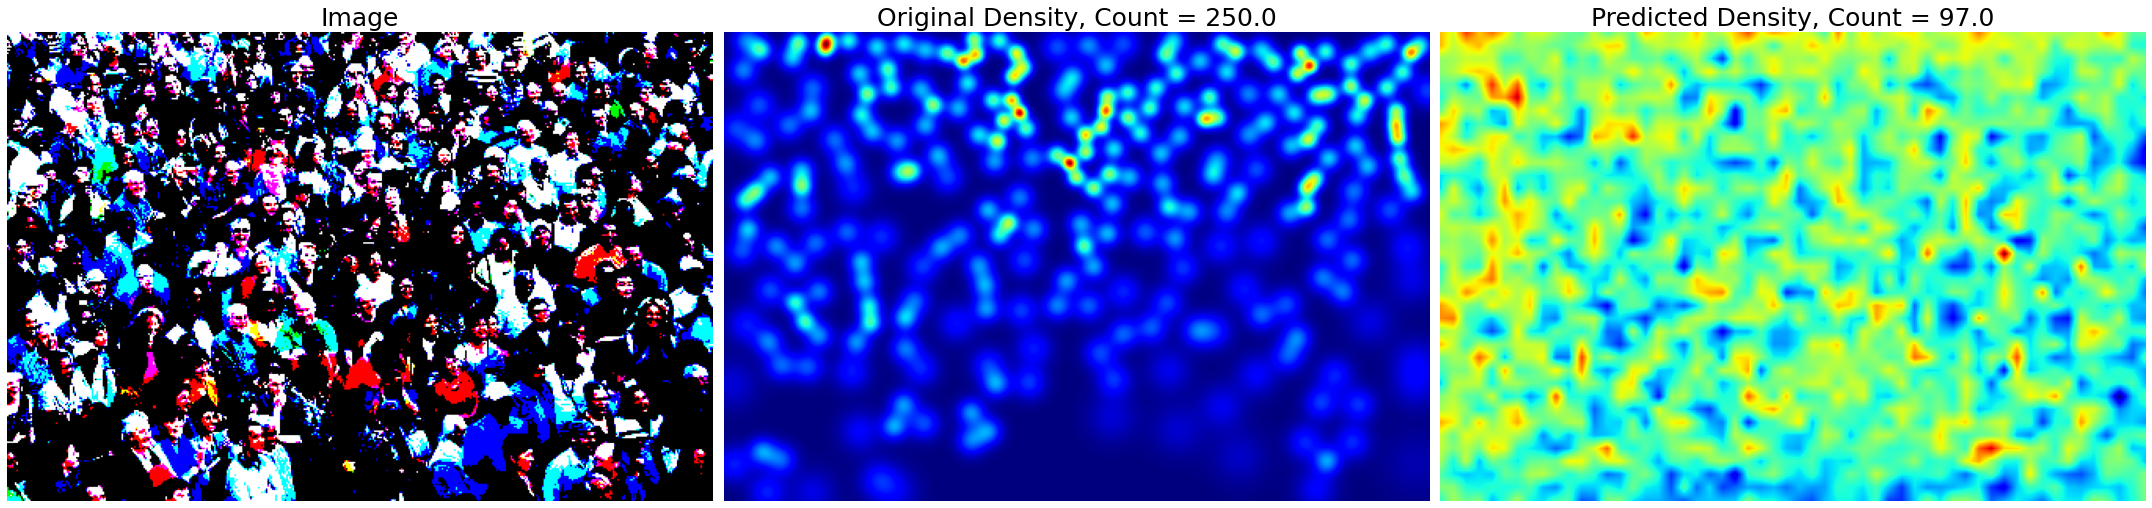

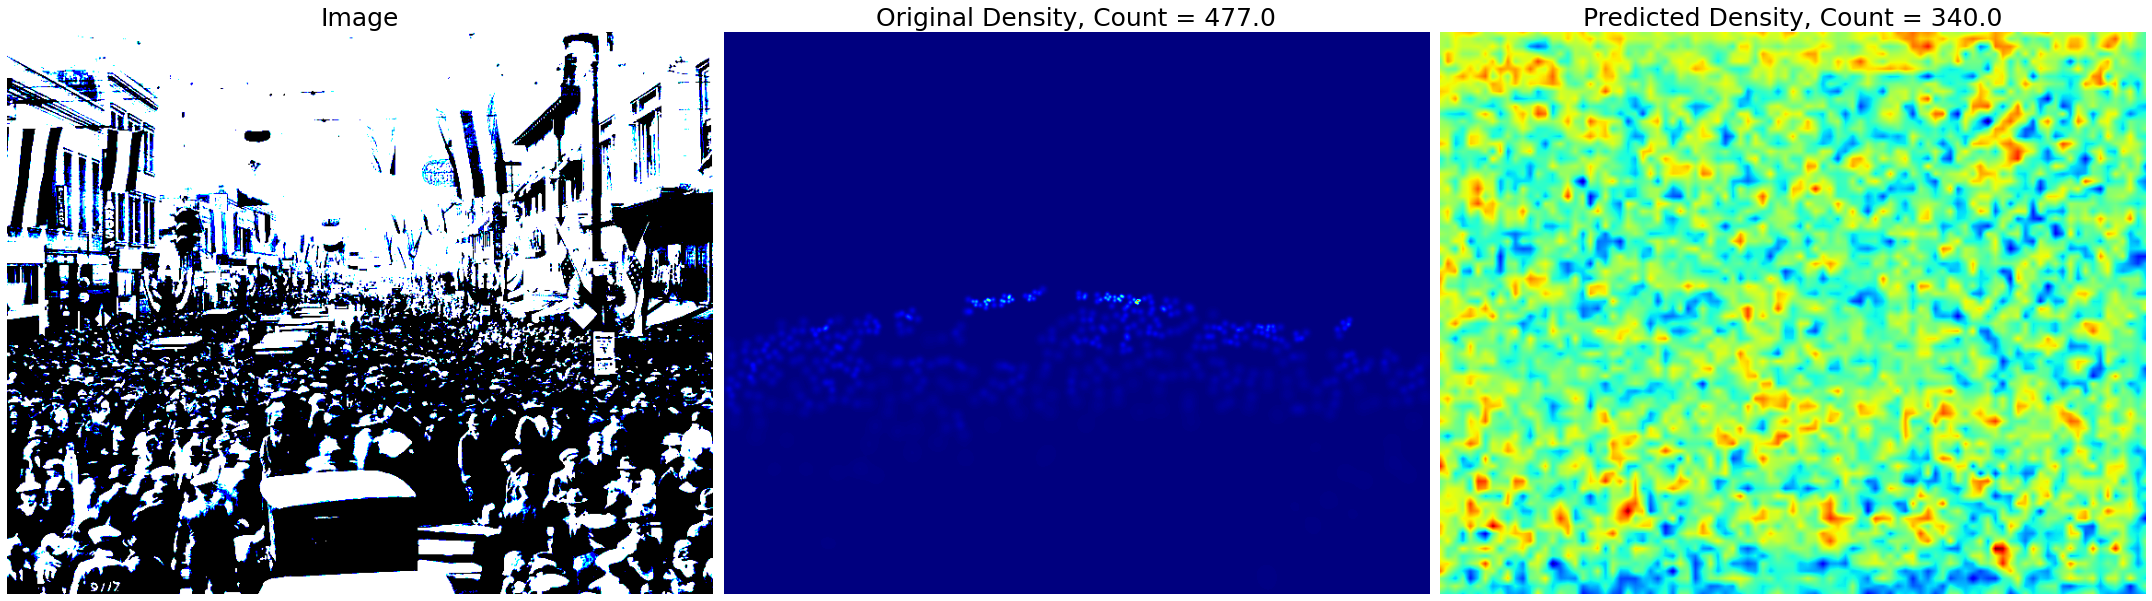

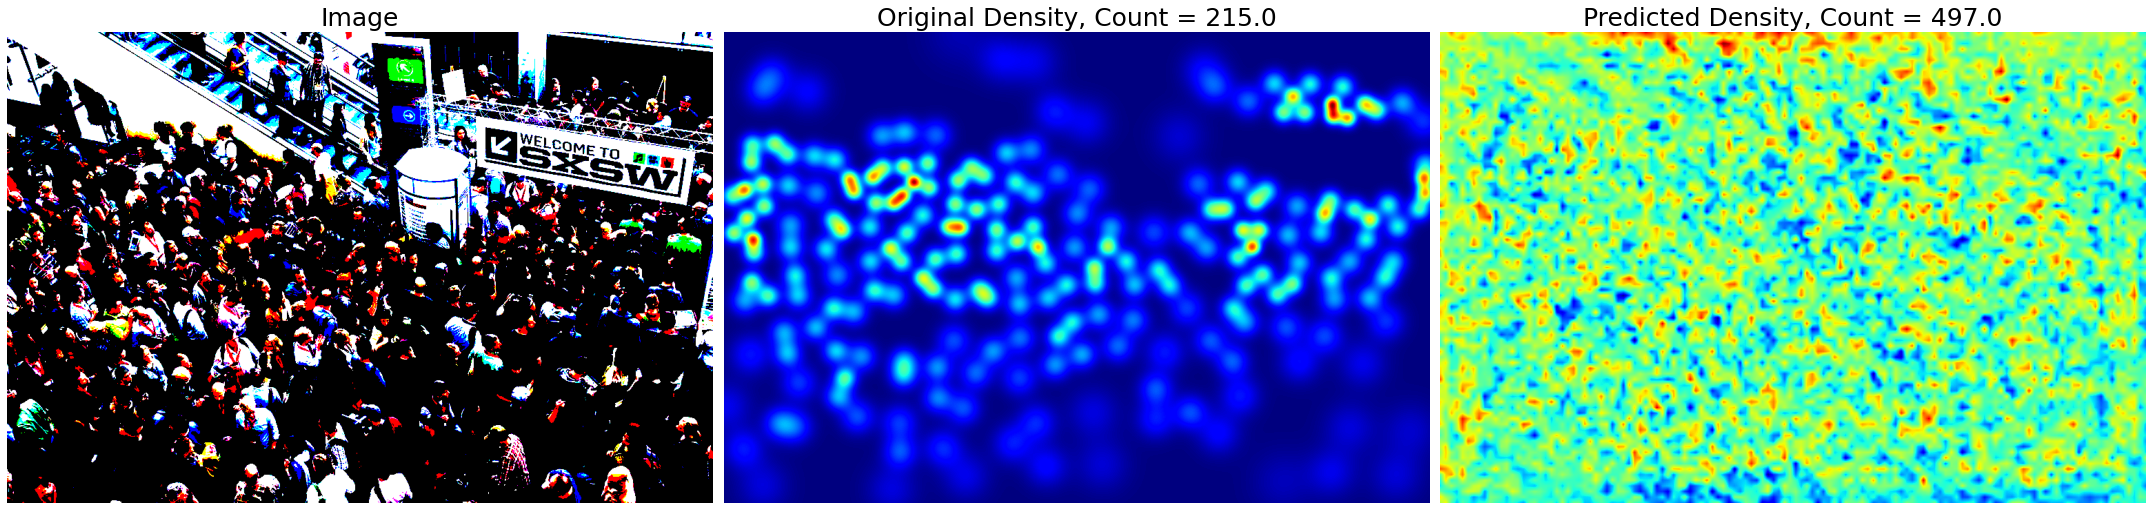

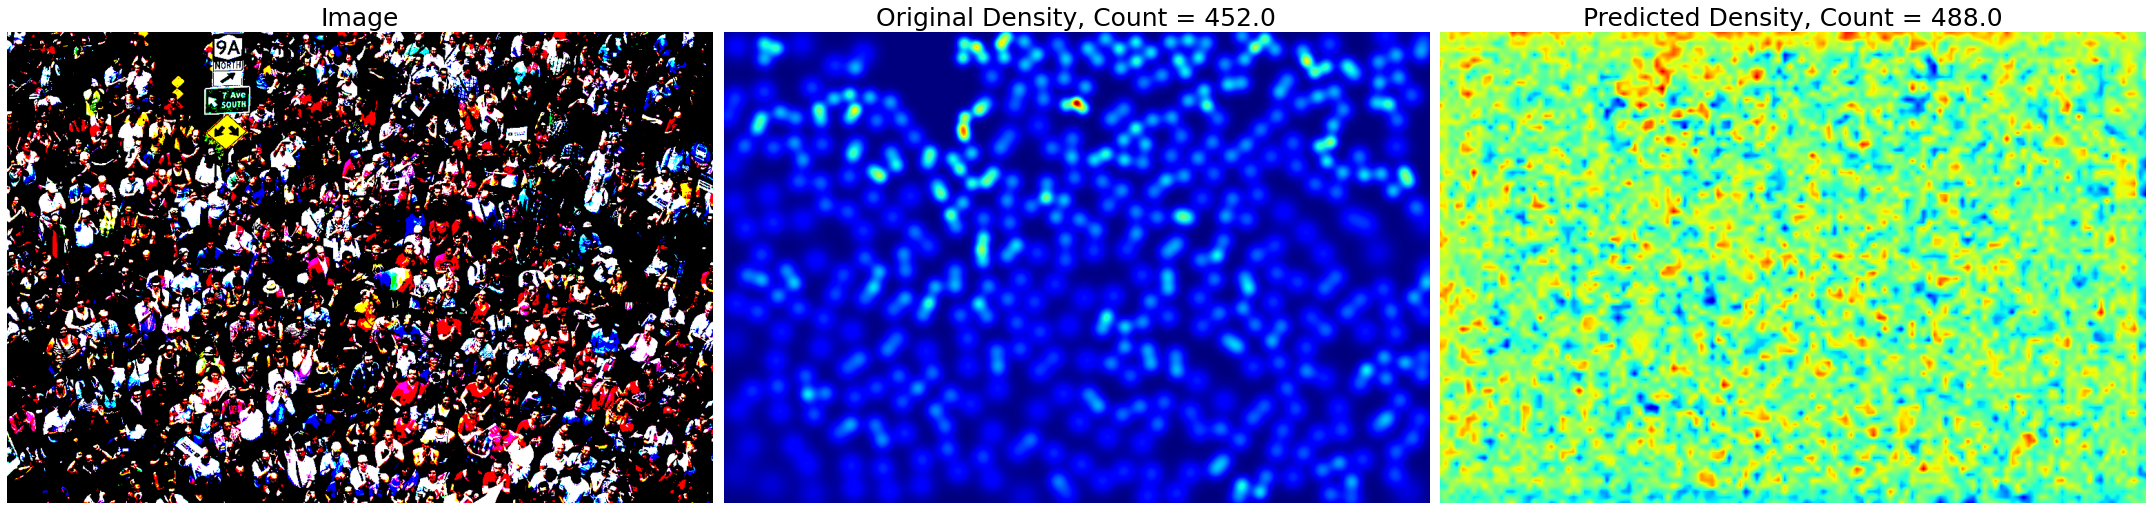

In [83]:
make_predictions(model, testLoader, 4)

### Observations:

The estimated count of #of persons present in the image is fairly ok, given the substantially less training epochs of the model.

The model seems to work well when the dataset image has sparse distribution of persons in it.

In [84]:
torch.save(model.state_dict(), 'csrnet_partA.pth')

### References:
    
1) Dataset link: https://github.com/gjy3035/Awesome-Crowd-Counting/blob/master/src/Datasets.md

2) Source code of the paper in Tensorflow: https://github.com/RTalha/CROWD-COUNTING-USING-CSRNET